In [9]:
weight0, weight1, weight2, bias0 ,bias1, bias2, loss_training_set ,loss_test_set = DNN()

0.0 % proceeding
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

training loss is 2.5149347659670824
test loss is 1.6118094750958207
0.9 accuracy!
2.0 % proceeding
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
confusionmatrix, top3matrix, top3matrix_index = ConfusionMatrix_n_top3(weight0, weight1, weight2, bias0 ,bias1, bias2,test_data)

# Module

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Loader

In [4]:
import gzip
import numpy as np
from pathlib import Path
import math
import random

class Dataloader():
    def __init__(self, path, is_train=True, shuffle=True, batch_size=8):
        path = Path(path)
        imagePath = Path(path/'train-images-idx3-ubyte.gz') if is_train else Path(path/'t10k-images-idx3-ubyte.gz')
        labelPath = Path(path/'train-labels-idx1-ubyte.gz') if is_train else Path(path/'t10k-labels-idx1-ubyte.gz')

        self.batch_size = batch_size
        self.images = self.loadImages(imagePath)
        self.labels = self.loadLabels(labelPath)
        self.index = 0
        self.idx = np.arange(0, self.images.shape[0])
        if shuffle: np.random.shuffle(self.idx) # shuffle images

    def __len__(self):
        n_images, _, _, _ = self.images.shape
        n_images = math.ceil(n_images / self.batch_size)
        return n_images

    def __iter__(self):
        return datasetIterator(self)

    def __getitem__(self, index):
        image = self.images[self.idx[index * self.batch_size:(index + 1) * self.batch_size]]
        label = self.labels[self.idx[index * self.batch_size:(index + 1) * self.batch_size]]
        image = image/255.0
        return image, label

    def loadImages(self, path):
        with gzip.open(path) as f:
            images = np.frombuffer(f.read(), 'B', offset=16)
            images = images.reshape(-1, 1, 28, 28).astype(np.float32)
            return images

    def loadLabels(self, path):
        with gzip.open(path) as f:
            labels = np.frombuffer(f.read(), 'B', offset=8)
            rows = len(labels)
            cols = labels.max() + 1
            one_hot = np.zeros((rows, cols)).astype(np.uint8)
            one_hot[np.arange(rows), labels] = 1
            one_hot = one_hot.astype(np.float64)
            return one_hot

# for enumerate magic python function returns Iterator
class datasetIterator():
    def __init__(self, dataloader):
        self.index = 0
        self.dataloader = dataloader

    def __next__(self):
        if self.index < len(self.dataloader):
            item = self.dataloader[self.index]
            self.index += 1
            return item
        # end of iteration
        raise StopIteration


# Function

In [5]:
def ReLU(value):
    return max(0, value)

def converter_ReLU(array):
    return np.array([ReLU(x) for x in array])

def zeroorone(value):
    if value > 0:
        return 1
    else:
        return 0
    
def converter_zeroorone_10(array):
    return np.array([zeroorone(x) for x in array.reshape(10)])

def converter_zeroorone_784(array):
    return np.array([zeroorone(x) for x in array.reshape(784)])

def SoftMax(z):
    c = np.max(z)
    exp_z = np.exp(z-c)
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y

def Cross_entrophy_loss(y_label, y_prediction):
    return -np.sum(y_label*np.log(y_prediction+1e-7))

In [6]:
def DNN(batchsize=100, epoch=50, testing = 1000):
    #ready for dataset
    learning_rate = batchsize/60000
    iteration = math.ceil(60000/batchsize)
    loss_training_set = []
    loss_test_set = []
    
    training_data = Dataloader(
        path="./",
        shuffle=True,
        batch_size=batchsize
    )
    test_data = Dataloader(
        path="./",
        shuffle=True,
        is_train = False,
        batch_size = 1
    )
    #initialize function
    weight0 = np.random.randn(784,784)
    weight1 = np.random.randn(784,784)
    weight2 = np.random.randn(784,10)
    bias0 = np.random.randn(784)
    bias1 = np.random.randn(784)
    bias2 = np.random.randn(10)
    
    for k in range(0,epoch):
        print(100*(k/epoch),"% proceeding")
        training_loss = 0
        error = 0
        test_loss = 0
        for i in range(0,iteration):
            #foward porpagation
            print("-",end='')
            delta_3 = np.zeros(10).reshape(1,10)
            delta_2 = np.zeros(784).reshape(1,784)
            delta_1 = np.zeros(784).reshape(1,784)
            chain_delta_3 = np.zeros(7840).reshape(784,10)
            chain_delta_2 = np.zeros(614656).reshape(784,784)
            chain_delta_1 = np.zeros(614656).reshape(784,784)
            for j in range(0, batchsize):
                #foward porpagation
                y_label = training_data.__getitem__(i)[1][j]
                
                layer_input = converter_zeroorone_784(training_data.__getitem__(i)[0][j]) 
                layer_1 = np.dot(layer_input, weight0)+bias0
                layer_1_ReLU = converter_ReLU(layer_1)
                
                layer_2 = np.dot(layer_1_ReLU,weight1)+bias1
                layer_2_ReLU = converter_ReLU(layer_2)
                
                layer_3 = np.dot(layer_2_ReLU, weight2)+bias2
                y_prediction = SoftMax(layer_3)
                training_loss += Cross_entrophy_loss(y_label,y_prediction)
                #Backwardpropagation weight2
                
                delta_3_b = ((y_prediction - y_label)/batchsize)
                chain_delta_3_b = np.dot(layer_2_ReLU.reshape(784,1), delta_3_b.reshape(1,10))
                
                #Backwardpropagation weight1
                
                delta_2_b = np.dot(delta_3_b,weight2.T)*converter_zeroorone_784(layer_2)
                chain_delta_2_b= np.dot(layer_1_ReLU.reshape(784,1), delta_2_b.reshape(1,784))
                
                #Backwardpropagation weight0
                
                delta_1_b = np.dot(delta_2_b,weight1.T)*converter_zeroorone_784(layer_1)
                chain_delta_1_b= np.dot(layer_input.reshape(784,1), delta_1_b.reshape(1,784))
                
                
                delta_3 += delta_3_b
                delta_2 += delta_2_b
                delta_1 += delta_1_b
                chain_delta_3 += chain_delta_3_b
                chain_delta_2 += chain_delta_2_b
                chain_delta_1 += chain_delta_1_b    
            weight2 -= (learning_rate * chain_delta_3)
            weight1 -= (learning_rate * chain_delta_2)
            weight0 -= (learning_rate * chain_delta_1)
            bias2 -= delta_3.reshape(10)*learning_rate
            bias1 -= delta_2.reshape(784)*learning_rate
            bias0 -= delta_1.reshape(784)*learning_rate
        print("\n")
        print("training loss is",training_loss/60000)
        loss_training_set.append(training_loss/60000)
        
        for i in range(0,testing):
            y_label = test_data.__getitem__(i)[1]
            layer_input = converter_zeroorone_784(test_data.__getitem__(i)[0]) 
            layer_1 = np.dot(layer_input, weight0)+bias0
            layer_1_ReLU = converter_ReLU(layer_1)
            layer_2 = np.dot(layer_1_ReLU,weight1)+bias1
            layer_2_ReLU = converter_ReLU(layer_2)
            layer_3 = np.dot(layer_2_ReLU, weight2)+bias2
            y_prediction = SoftMax(layer_3)
            test_loss += Cross_entrophy_loss(y_label,y_prediction)
            if(np.argmax(y_prediction)!=np.argmax(test_data.__getitem__(i)[1])):
                error += 1
        print("test loss is",test_loss/testing)
        print(1-(error/testing),"accuracy!")
        loss_test_set.append(test_loss/testing)
    return weight0, weight1, weight2, bias0 ,bias1, bias2, loss_training_set ,loss_test_set

In [12]:
test_data = Dataloader(
    path="./",
    shuffle=True,
    is_train = False,
    batch_size = 1
)

In [11]:
def ConfusionMatrix_n_top3(weight0, weight1, weight2, bias0 ,bias1, bias2, test_data):
    confusionmatrix = np.zeros(100).reshape(10,10)
    top3matrix = np.zeros(30).reshape(10,3)
    top3matrix_index = np.zeros(30).reshape(10,3)
    for i in range(0,10000):
        y_label = test_data.__getitem__(i)[1]
        layer_input = converter_zeroorone_784(test_data.__getitem__(i)[0]) 
        layer_1 = np.dot(layer_input, weight0)+bias0
        layer_1_ReLU = converter_ReLU(layer_1)
        layer_2 = np.dot(layer_1_ReLU,weight1)+bias1
        layer_2_ReLU = converter_ReLU(layer_2)
        layer_3 = np.dot(layer_2_ReLU, weight2)+bias2
        y_prediction = SoftMax(layer_3)
        
        #confusionmatrix
        confusionmatrix[np.argmax(y_label)][np.argmax(y_prediction)]+=1
        index = np.argmin(top3matrix[np.argmax(y_prediction)])
        if top3matrix[np.argmax(y_prediction)][index] <= y_prediction[np.argmax(y_prediction)]:
            top3matrix[np.argmax(y_prediction)][index] =  y_prediction[np.argmax(y_prediction)]
            top3matrix_index[np.argmax(y_prediction)][index] = i
            
    return confusionmatrix , top3matrix, top3matrix_index

# Loss graph

In [14]:
index = [x for x in range(50)]

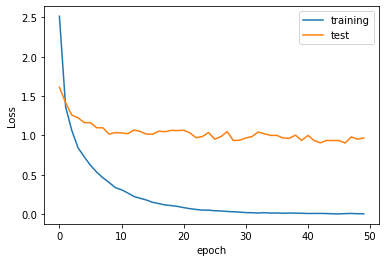

In [15]:
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.plot(index,loss_training_set)
plt.plot(index,loss_test_set)
plt.legend(['training', 'test'])
plt.show()

# Confusion Matrix

In [16]:
confusionmatrix_visualization = np.array([(100*x)/np.sum(x) for x in confusionmatrix])

In [17]:
confusionmatrix_visualization = np.array([ np.fix(x) for x in confusionmatrix])

In [18]:
confusionmatrix_visualization.astype(int)

array([[ 959,    0,    6,    0,    2,    4,    5,    2,    0,    2],
       [   2, 1099,    7,    4,    1,    1,    4,    1,   16,    0],
       [   2,    7,  975,   10,    3,    1,    4,   11,   18,    1],
       [   2,    3,   10,  931,    1,   21,    1,   14,   20,    7],
       [   1,    1,    4,    0,  922,    1,    7,    7,   12,   27],
       [   5,    3,    1,   26,    1,  823,    9,    1,   16,    7],
       [  10,    5,    4,    0,   10,    8,  912,    1,    7,    1],
       [   2,    4,   14,   14,    8,    2,    0,  959,    5,   20],
       [  10,    6,    8,   15,    7,    7,    3,    6,  901,   11],
       [   3,    6,    0,    8,   20,    5,    1,   17,    5,  944]])

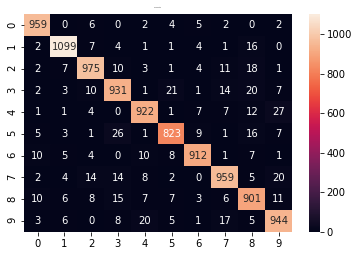

In [19]:
sns.heatmap(confusionmatrix_visualization.astype(int), annot=True, fmt='d')

plt.title('confusionmatrix', fontsize=1)

plt.show()

# Top-3 images with probability

In [20]:
print(top3matrix)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


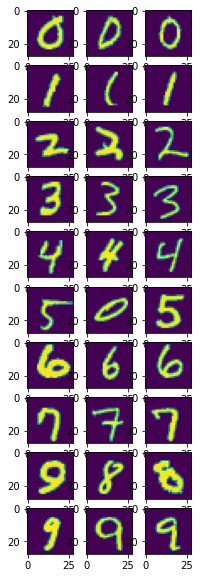

In [22]:
fig, axes = plt.subplots(10,3, figsize=(3,10))
j=0
for i,ax in enumerate(axes.flat):
    index = math.ceil(top3matrix_index.reshape(30)[j])
    ax.imshow(test_data.__getitem__(index)[0].reshape(28,28))
    j+=1